### Colab Setup

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
!pip install -q johnsnowlabs

In [ ]:
from johnsnowlabs import *

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.install(refresh_install=True, visual=True, force_browser = True)

In [3]:
from johnsnowlabs import *

from pyspark.ml import PipelineModel
from pyspark.sql import functions as F
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Automatically load licenste data and start a session with all jars user has access to
spark = nlp.start(visual = True)

👌 Launched cpu optimized session with with: 🚀Spark-NLP==4.3.2, 💊Spark-Healthcare==4.3.2, 🕶Spark-OCR==4.3.3, running on ⚡ PySpark==3.1.2


## Load sample pdf file

Here, we will use page 70 as an exmaple from CF_Industries PDF file to save inference time.

In [4]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/finance-nlp/data/solution_accelerator_esg_and_rr/cf_industries_page_70.pdf


    Image #0:
    Origin: file:/content/cf_industries_page_70.pdf
    Resolution: 300 dpi
    Width: 5691 px
    Height: 3200 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


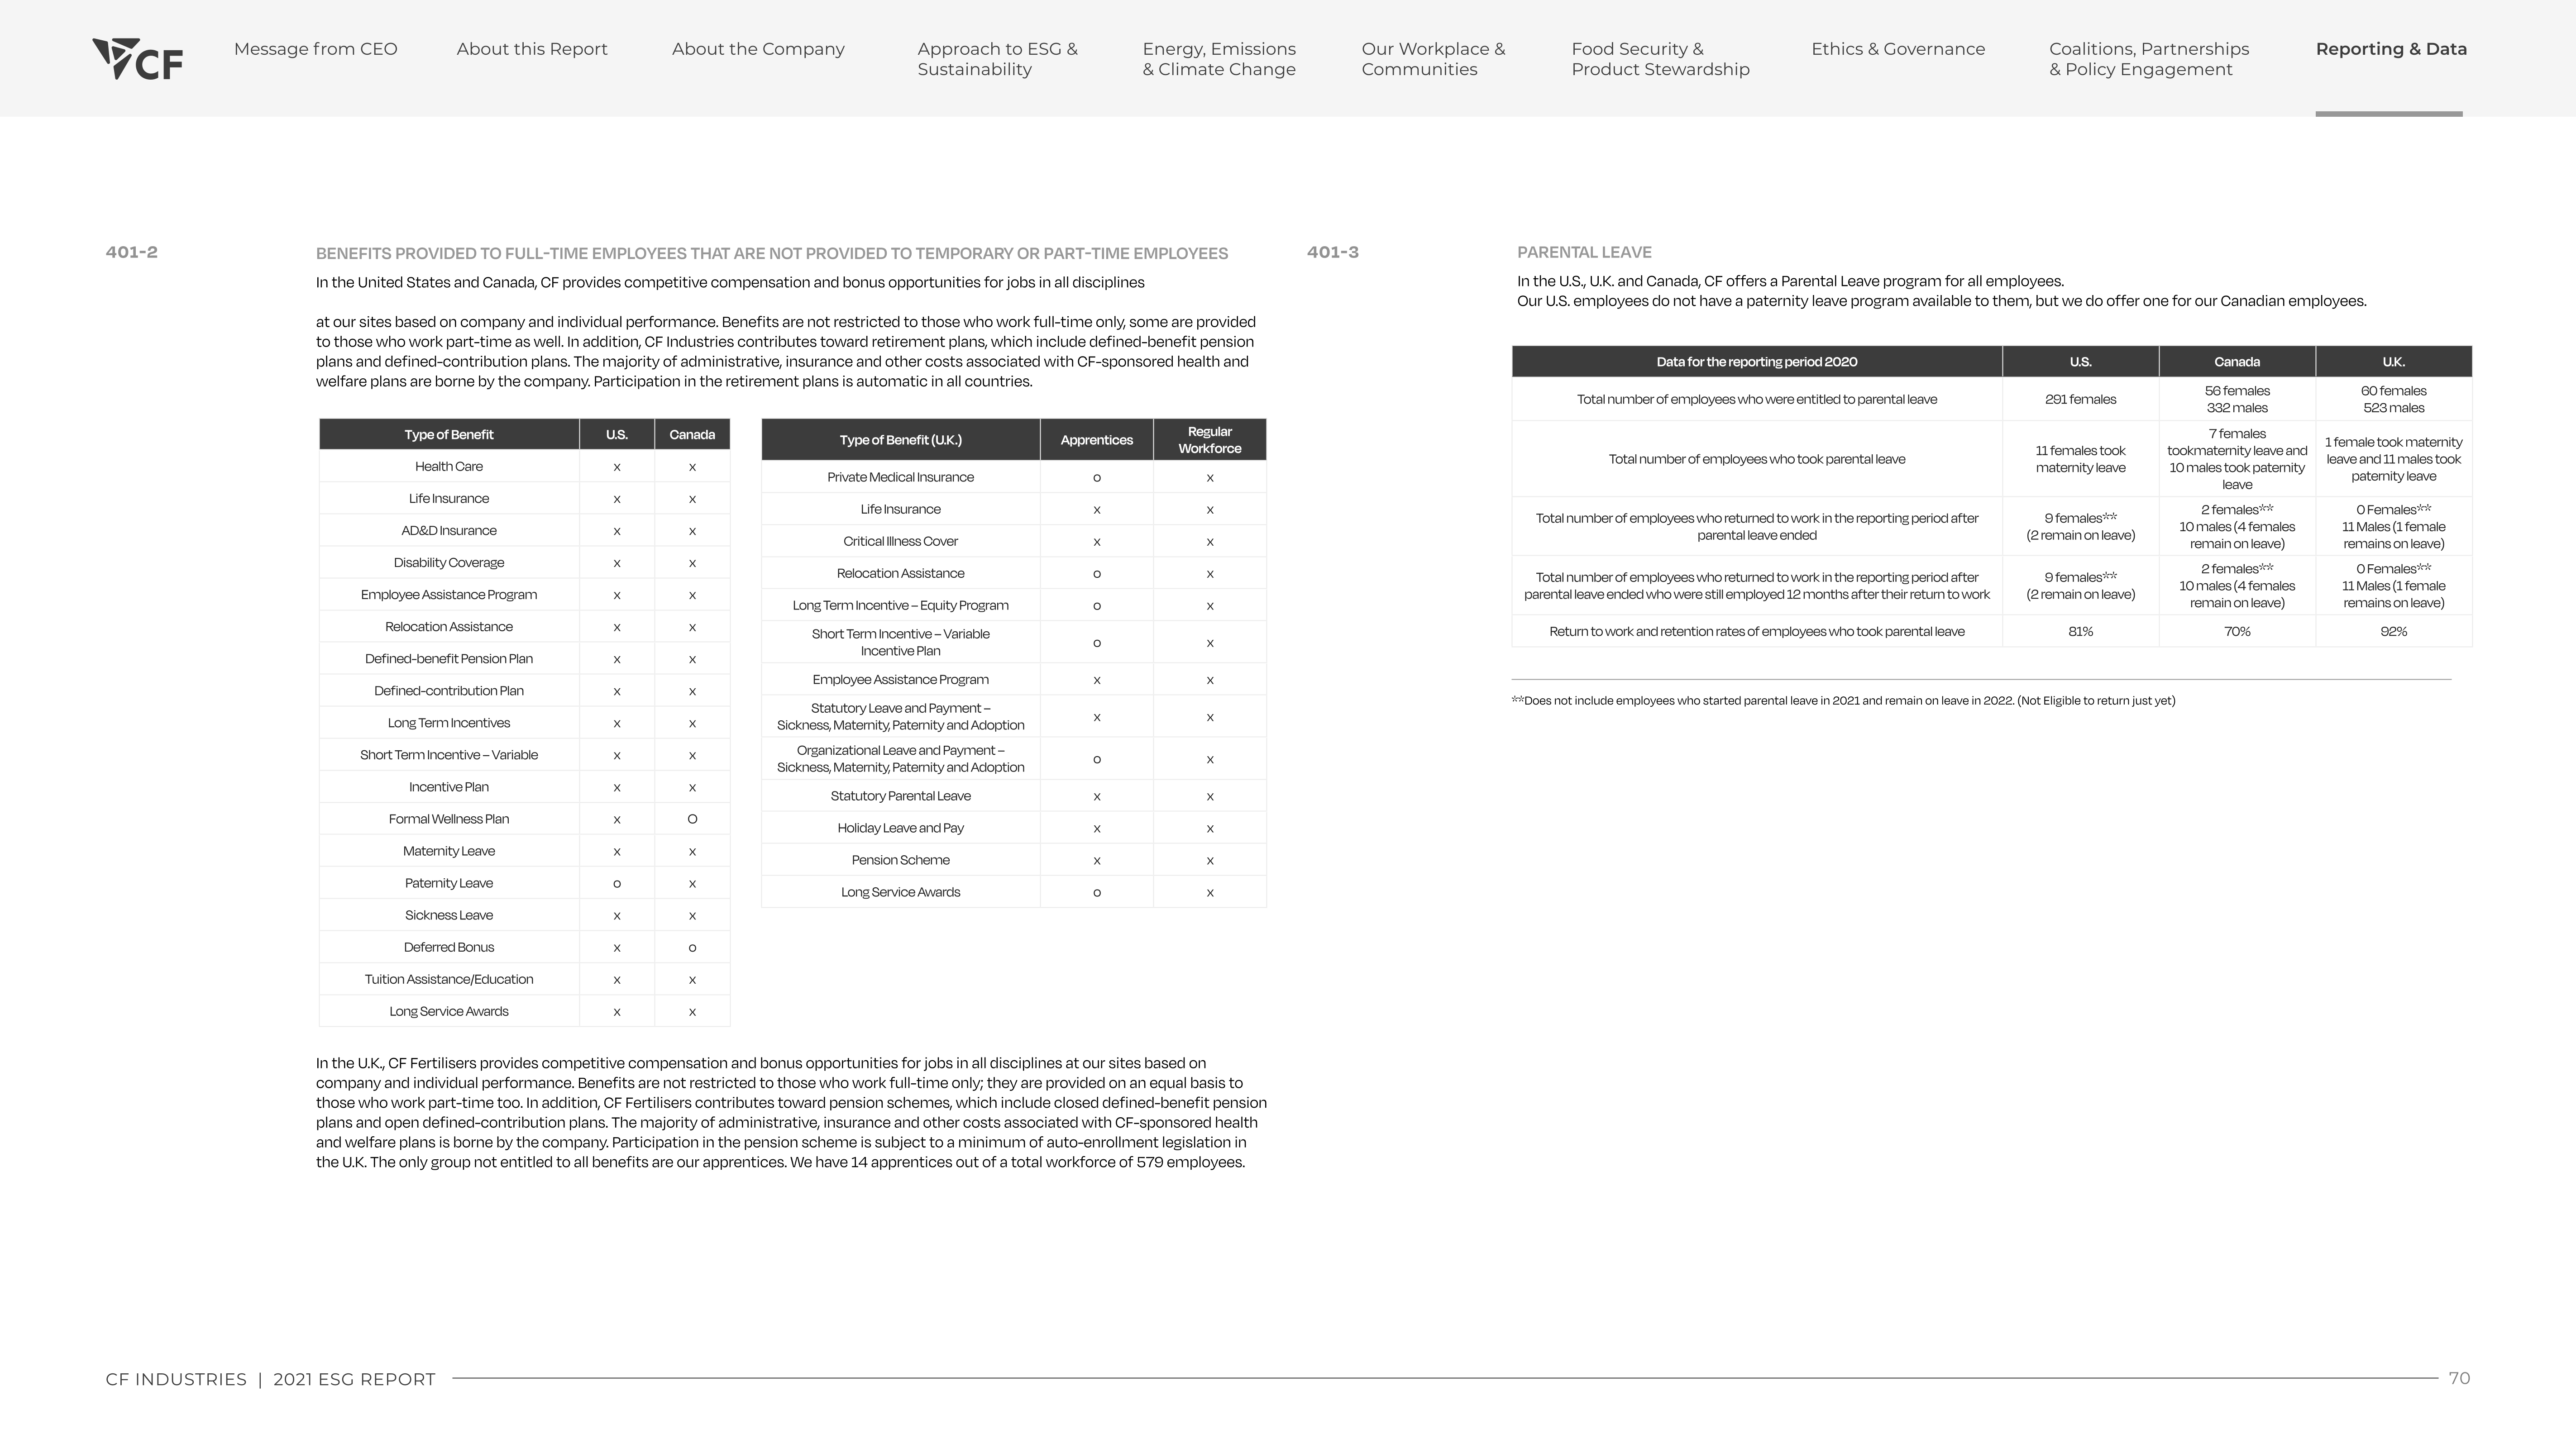

In [5]:
pdf_path = './cf_industries_page_70.pdf'

pdf_example_df = spark.read.format("binaryFile").load(pdf_path).cache()

visual.display_pdf(pdf_example_df)

## Table data extraction

To get table from PDF file, we use SparkNLP OCR components

In [6]:
binary_to_image = visual.BinaryToImage()
binary_to_image.setOutputCol("image")
binary_to_image.setImageType(visual.ImageType.TYPE_3BYTE_BGR)

# Detect tables on the page using pretrained model
# It can be finetuned for have more accurate results for more specific documents
table_detector = visual.ImageTableDetector.pretrained("general_model_table_detection_v2", "en", "clinical/ocr")
table_detector.setInputCol("image")
table_detector.setOutputCol("region")

# Draw detected region's with table to the page
draw_regions = visual.ImageDrawRegions()
draw_regions.setInputCol("image")
draw_regions.setInputRegionsCol("region")
draw_regions.setOutputCol("image_with_regions")
draw_regions.setRectColor(visual.Color.red)

# Extract table regions to separate images
splitter = visual.ImageSplitRegions()
splitter.setInputCol("image")
splitter.setInputRegionsCol("region")
splitter.setOutputCol("table_image")
splitter.setDropCols("image")

# Detect cells on the table image
cell_detector = visual.ImageTableCellDetector()
cell_detector.setInputCol("table_image")
cell_detector.setOutputCol("cells")
cell_detector.setAlgoType("morphops")
cell_detector.setDrawDetectedLines(True)

# Extract text from the detected cells 
table_recognition = visual.ImageCellsToTextTable()
table_recognition.setInputCol("table_image")
table_recognition.setCellsCol('cells')
table_recognition.setMargin(3)
table_recognition.setStrip(True)
table_recognition.setOutputCol('table')

# Erase detected table regions
fill_regions = visual.ImageDrawRegions()
fill_regions.setInputCol("image")
fill_regions.setInputRegionsCol("region")
fill_regions.setOutputCol("image_1")
fill_regions.setRectColor(visual.Color.white)
fill_regions.setFilledRect(True)

# OCR
ocr = visual.ImageToText()
ocr.setInputCol("image_1")
ocr.setOutputCol("text")
ocr.setOcrParams(["preserve_interword_spaces=1", ])
ocr.setKeepLayout(True)
ocr.setOutputSpaceCharacterWidth(8)

general_model_table_detection_v2 download started this may take some time.
Approximate size to download 264.7 MB


ImageToText_6e783ff076c6

## Processing of PDF


In [7]:
pdf_to_image = visual.PdfToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setImageType(visual.ImageType.TYPE_3BYTE_BGR) \
    .setKeepInput(True)

pipeline_table_pdf = PipelineModel(stages=[
    pdf_to_image,
    table_detector,
    draw_regions,
    fill_regions,
    splitter,
    cell_detector,
    table_recognition,
    ocr
])

tables_results_pdf = pipeline_table_pdf.transform(pdf_example_df).cache()


    Image #0:
    Origin: file:/content/cf_industries_page_70.pdf
    Resolution: 0 dpi
    Width: 5691 px
    Height: 3200 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


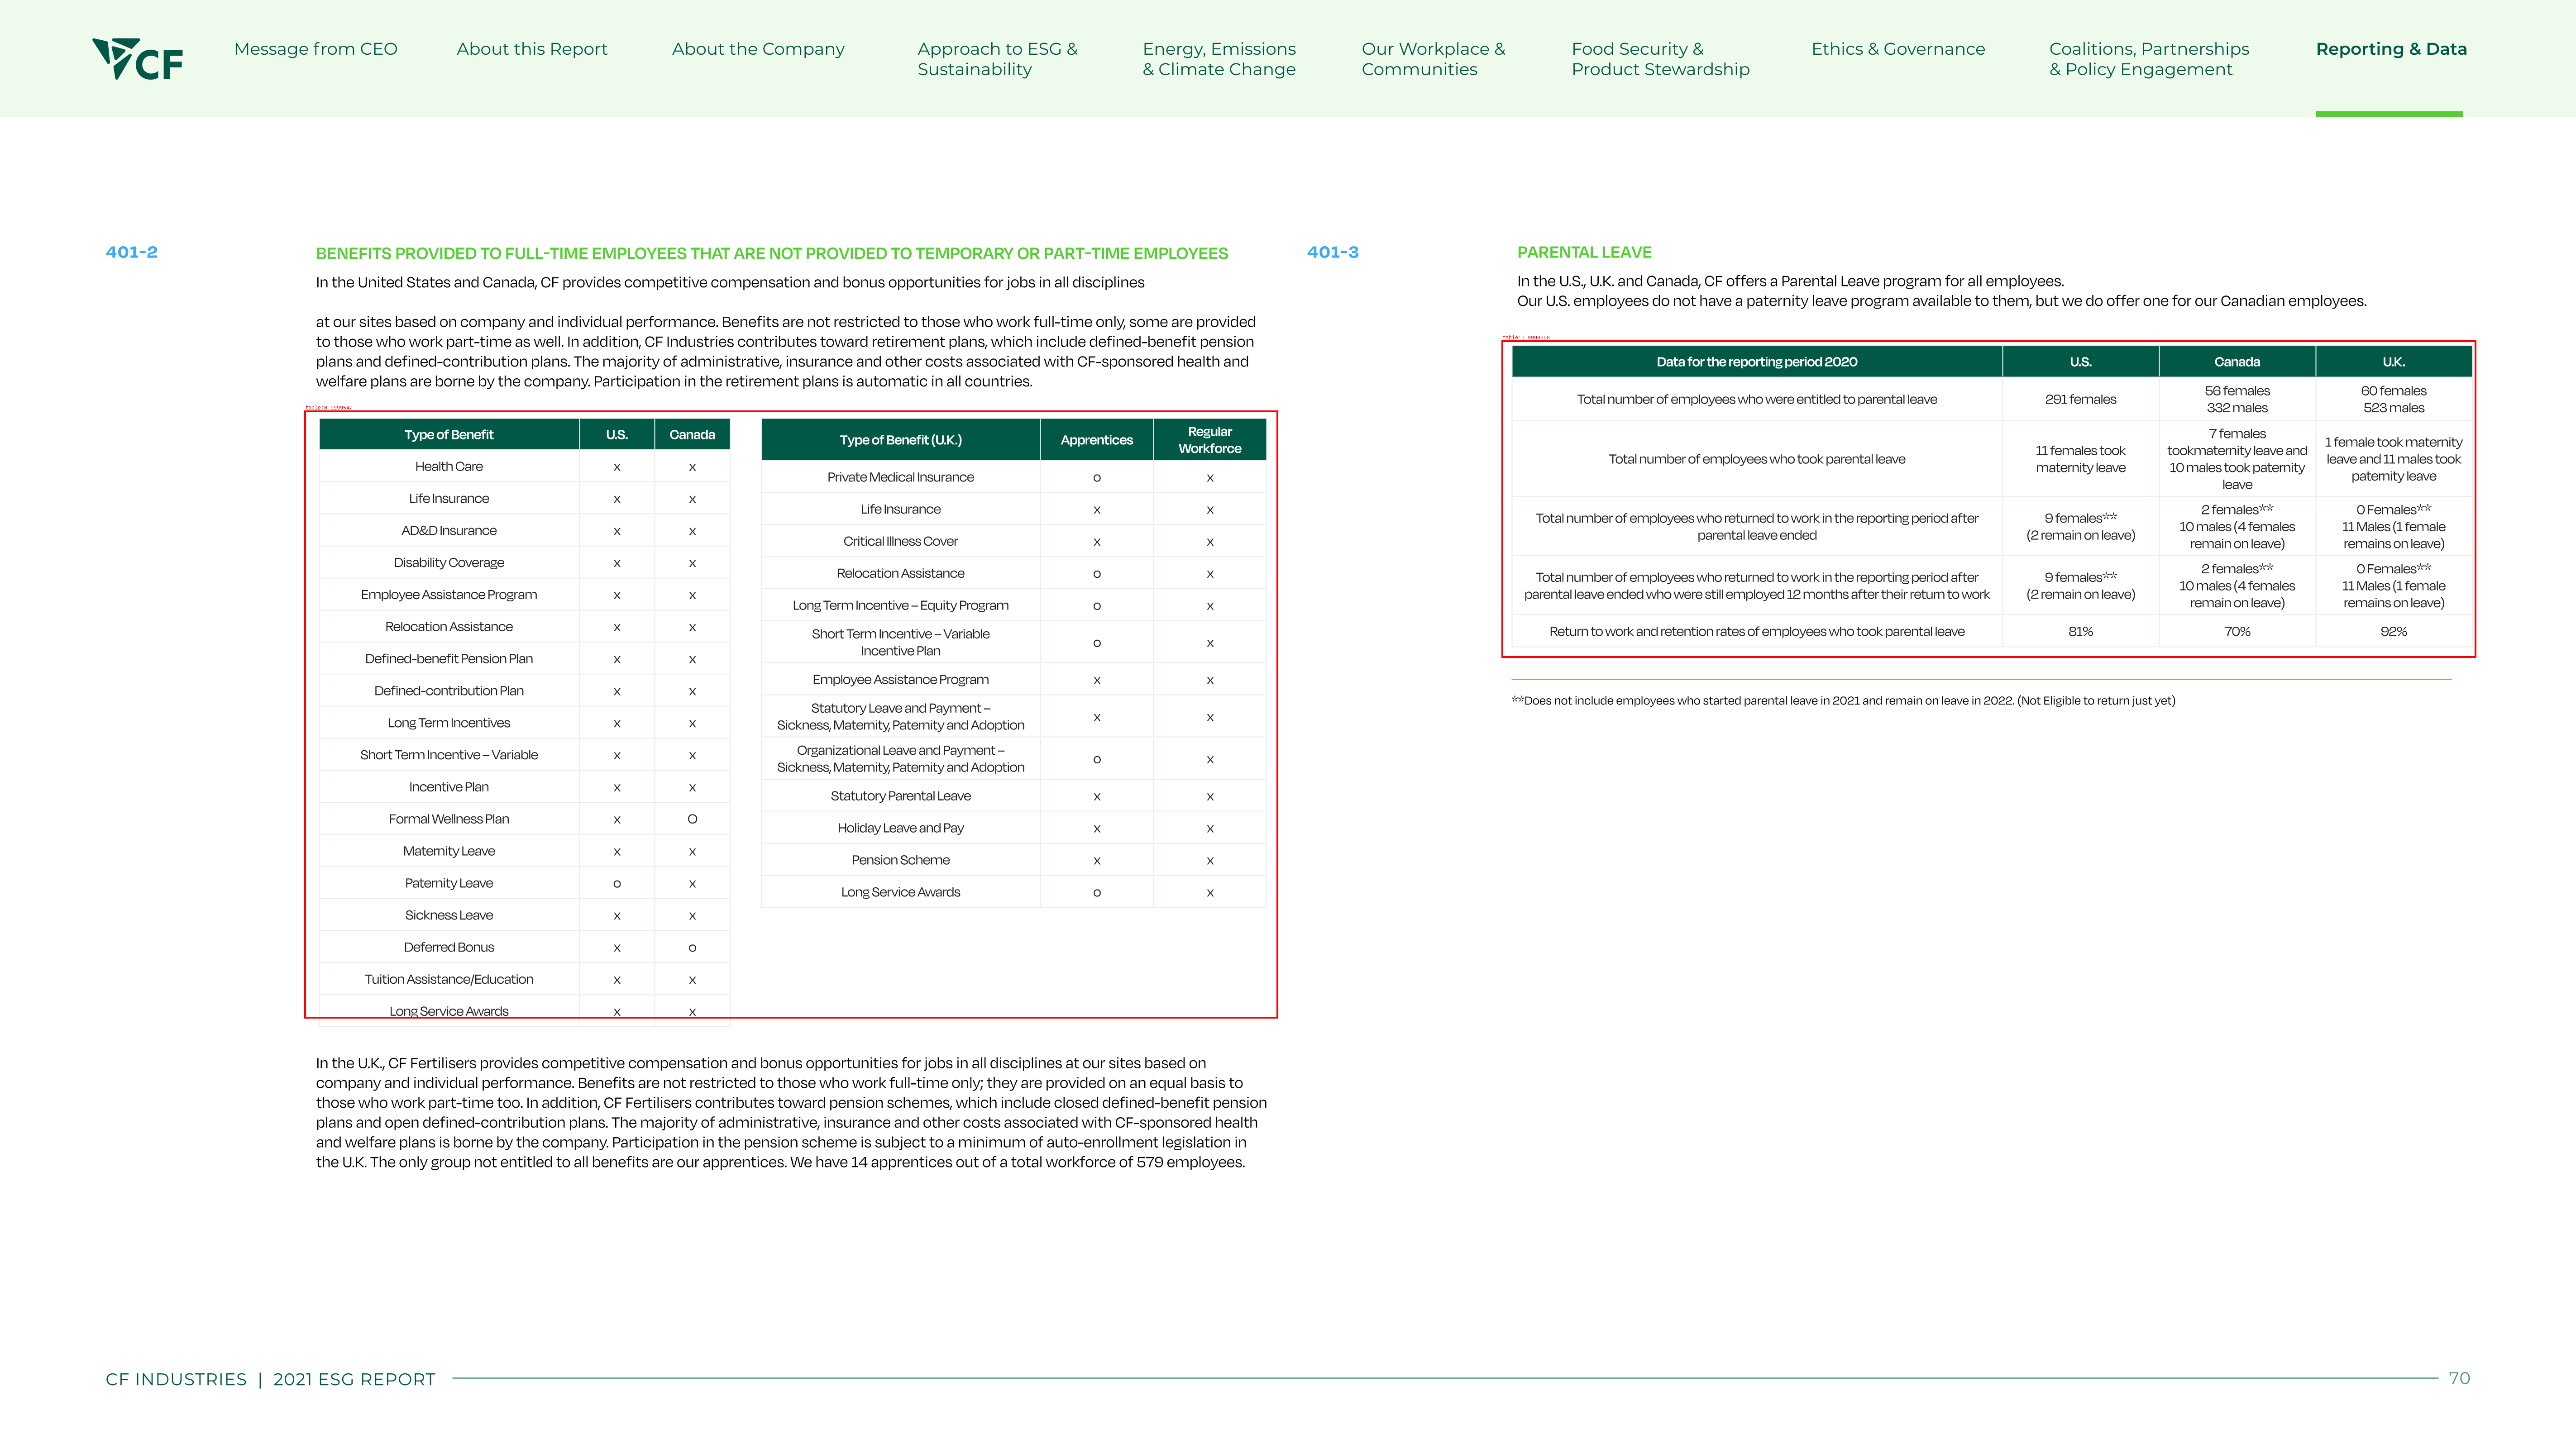

CPU times: user 1.46 s, sys: 322 ms, total: 1.78 s
Wall time: 1min 16s


In [8]:
%%time
visual.display_images(tables_results_pdf, "image_with_regions", limit=1)

Table extracted from pdf

In [9]:
pd.set_option('max_colwidth', 500)
visual.display_tables(tables_results_pdf)

Filename: cf_industries_page_70.pdf
Page:     0
Table:    0
5


,col0,col1,col2,col3,col4
0,J,Data for the reporting period 2020,US.,Canada,
1,,Total number of employees who were entitled to parental leave,291 females,56 females332 males,60 females523 males
2,,Total number of employees who took parental leave,11 females tookmaternity leave,7 femalestookmaternity leave and10 males took paternityleave,1 female took maternityleave and 11 males tookpaternity leave
3,,Total number of employees who returned to work in the reporting period afterparental leave ended,9 females**(2 remain on leave),2 females**10 males (4 femalesremain on leave),OFemales**11 Males (1 femaleremains on leave)
4,L,Total number of employees who returned to work in the reporting period afteryarental leave encled who were still employed 12 months after their return to work,9 females**(2 remain on leave),2 females**10 males (4 femalesremain on leave),OFemales**11 Males (1 femaleremains on leave)
5,L,Return to work and retention rates of employees who took parental leave,81%,70%,92%


Filename: cf_industries_page_70.pdf
Page:     0
Table:    1
8


,col0,col1,col2,col3,col4,col5,col6,col7
0,Type of Benefit,=,——Canada_—_—_—_—_—E—_,,Type of Benefit (U.K.),eeApprentices,————te70) (1gWorkforce,m
1,Health Care,x,x,,Private Medical Insurance,O°,x,
2,Life Insurance,x,x,po,Life Insurance,x,x,
3,AD&D Insurance,x,x,,Critical Illness Cover,x,x,
4,Disability Coverage,x,x,,Relocation Assistance,Oo,x,
5,Employee Assistance Program,x,x,P,Long Term Incentive - Equity Program,O°,x,
6,Relocation AssistanceDefined-benefit Pension Plan,xx,xx,,Short Term Incentive — VariableIncentive Plan,O°,x,
7,Defined-contribution Plan,x,x,pf,Employee Assistance Program,x,x,
8,,>—————_,,,Statutorv Leave and Pavment —,,,
9,Long Term Incentives,x,x,pd,"Sickness, Maternity, Paternity and Adoption",Aw,Aw,


## We will continue with first table

### Let's create an example table and some questions using information in the first table

In [10]:
json_data = """
{
  "header": ["Data for the reporting period 2020",	"US",	"Canada", "UK"],
  "rows": [
    ["Total number of employees who were entitled to parental leave", "291 females", "56 females, 332 males", "60 females, 523 males"],
    ["Total number of employees who took parental leave", "11 females took maternity leave", "7 females took maternity leave and 10 males took paternity leave", "1 female took maternity leave and 11 males took paternity leave"],
    ["Return to work and retention rates of employees who took parental leave", "81%", "70%", "92%"]
  ]
}
"""

queries = [
    "What is the total number of employees entitled to parental leave in Canada?",
    "How many employees took parental leave in the US?", 
    "What are the return to work and retention rates of employees who took parental leave in UK?",
]

In [11]:
data = spark.createDataFrame([
        [json_data, " ".join(queries)]
    ]).toDF("table_json", "questions")


- TAPAS needs a specific annotator, called `MultiDocumentAssembler` to assemble the table and the questions.

- Then, we tell Spark NLP to manage document_table column as a table using a new annotator, `TableAssembler`

- Last component is `TapasForQuestionAnswering`, which will carry out the inference process


In [12]:
document_assembler = nlp.MultiDocumentAssembler() \
    .setInputCols("table_json", "questions") \
    .setOutputCols("document_table", "document_questions")

text_splitter = finance.TextSplitter() \
    .setInputCols(["document_questions"]) \
    .setOutputCol("questions")

table_assembler = nlp.TableAssembler()\
    .setInputCols(["document_table"])\
    .setOutputCol("table")

tapas = nlp.TapasForQuestionAnswering.pretrained("table_qa_tapas_base_finetuned_sqa", "en")\
    .setInputCols(["questions", "table"])\
    .setOutputCol("answers")

pipeline = nlp.Pipeline(stages=[
    document_assembler,
    text_splitter,
    table_assembler,
    tapas
])

table_qa_tapas_base_finetuned_sqa download started this may take some time.
Approximate size to download 394.7 MB
[OK!]


In [13]:
model = pipeline.fit(data)

In [14]:
result = model.transform(data)

In [15]:
result.select(F.explode(F.arrays_zip(result.questions.result, result.answers.result)).alias("cols"))\
      .select(F.expr("cols['0']").alias("question"), 
              F.expr("cols['1']").alias("answer")).show(truncate=False)

+-------------------------------------------------------------------------------------------+---------------------+
|question                                                                                   |answer               |
+-------------------------------------------------------------------------------------------+---------------------+
|What is the total number of employees entitled to parental leave in Canada?                |56 females, 332 males|
|How many employees took parental leave in the US?                                          |291 females          |
|What are the return to work and retention rates of employees who took parental leave in UK?|92%                  |
+-------------------------------------------------------------------------------------------+---------------------+



Here we used `table_qa_tapas_base_finetuned_sqa` model.

TAPAS models have been trained using a combination of three datasets:
- [SQA](https://www.microsoft.com/en-us/download/details.aspx?id=54253), Sequential Question Answering by Microsoft (it was not trained to return aggregation operations as SUM, COUNT etc.)
- [WTQ](https://github.com/ppasupat/WikiTableQuestions), Wiki Table Questions by Stanford University (with aggregation operations)
- [WikiSQL](https://github.com/salesforce/WikiSQL), by Salesforce, also with aggregation operations.

As mentioned before, TAPAS models can return aggregation operation, if they are trained to do so:
-  All WTQ or WikiSQL models  returning those operations as part of the answer to the qustion, if required. The operations are: AVERAGE, SUM, COUNT.
- SQA models don't return any aggregation operation, just the answer in human language.

You can try the `table_qa_tapas_base_finetuned_wtq` model with different tables to apply aggregation functions